# Лабораторная работа №3 по Цифровой Обработке Изображений на тему "Классификация изображений с использованием Свёрточных Нейронных Сетей"

- [Набор данных](#Набор-данных)
    - [Тестовые изображения](#Тестовые-изображения)
- [Аугментации данных](#Аугментации-данных)
- [Генераторы изображений](#Генераторы-изображений)
- [Модели](#Модели)
- [Обучение](#Обучение)
- [Тестирование](#Тестирование)

## Набор данных

Набор данных состоит из изображений разрешением 170x170 пикселей и разделён на две части: обучающую и тестовую. Обучающая и тестовая части разделены на два класса: собаки породы Чихуахуа и маффины.

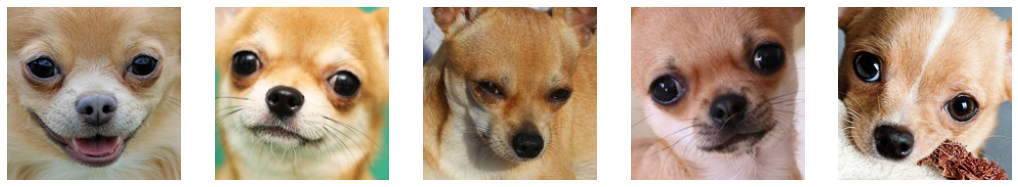

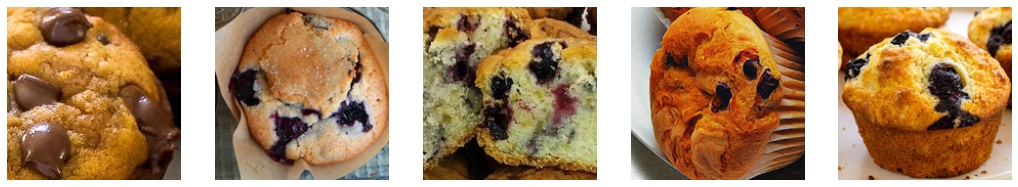

In [1]:
import os
from numpy.random import default_rng
import matplotlib.pyplot as plt
%matplotlib inline


TRAIN_PATH = os.path.join(os.getcwd(), 'dataset', 'train')
TEST_PATH = os.path.join(os.getcwd(), 'dataset', 'test')


def show_images(path, shape, figsize, *, suptitle=None):
    n_rows, n_columns = shape
    
    file_names = os.listdir(path)
    
    rng = default_rng()
    random_file_names = rng.choice(file_names, size=(n_rows * n_columns), replace=False)
    
    fig, axes = plt.subplots(*shape, figsize=figsize)
    axes = axes.flatten()
    for ax, random_file_name in zip(axes, random_file_names):
        random_image = plt.imread(os.path.join(path, random_file_name))
        ax.imshow(random_image)
        ax.set_axis_off()
    fig.suptitle(suptitle, fontsize=20)
    plt.show(fig)
    
    
show_images(os.path.join(TRAIN_PATH, 'Chihuahua'), (1, 5), (18, 4))
show_images(os.path.join(TRAIN_PATH, 'Muffin'), (1, 5), (18, 4))

### Тестовые изображения

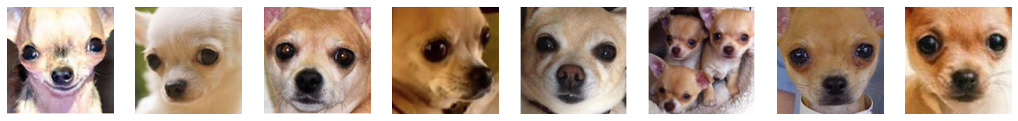

In [2]:
show_images(os.path.join(TEST_PATH, 'Chihuahua'), (1, 8), (18, 4))

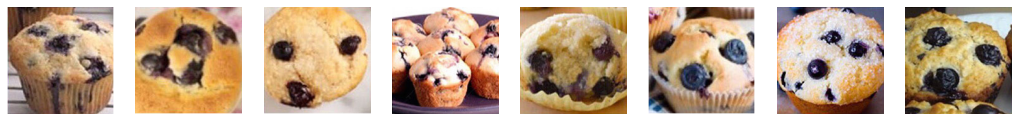

In [3]:
show_images(os.path.join(TEST_PATH, 'Muffin'), (1, 8), (18, 4))

### Настройка CPU/GPU

In [4]:
from tensorflow.config.experimental import set_visible_devices


set_visible_devices([], 'GPU')

## Аугментации данных

Давайте взглянем на примеры аугментации данных. Какие они бывают.

Found 109 images belonging to 2 classes.


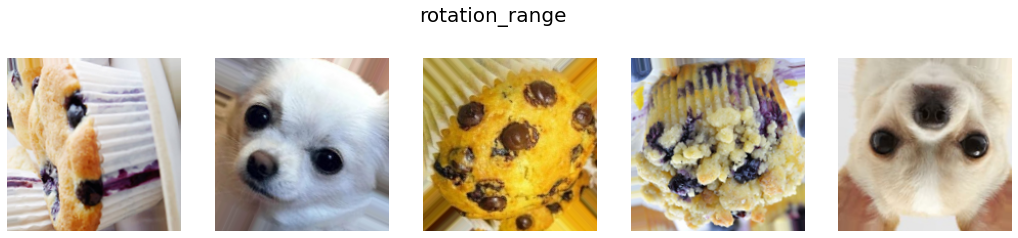

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def show_augmentaion(augmentaion, **kwargs):
    path = os.path.join(os.getcwd(), 'Dataset', 'augmentations', augmentaion)
    
    # удаляем содержимое папки, если оно есть
    file_names = os.listdir(path)
    if file_names:
        for file_name in file_names:
            os.remove(os.path.join(path, file_name))
    
    augmentaion_generator = ImageDataGenerator(**kwargs)
    augmentaion_datagen = augmentaion_generator.flow_from_directory(
        TRAIN_PATH,
        target_size=(170, 170),
        save_to_dir=path,
        save_format='png',
    )
    next(augmentaion_datagen)
    show_images(path, (1, 5), (18, 4), suptitle=augmentaion)


show_augmentaion('rotation_range', rotation_range=180)

Found 109 images belonging to 2 classes.


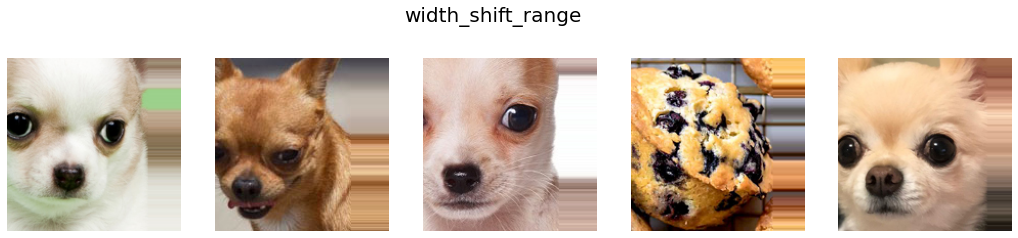

In [6]:
show_augmentaion('width_shift_range', width_shift_range=50)

Found 109 images belonging to 2 classes.


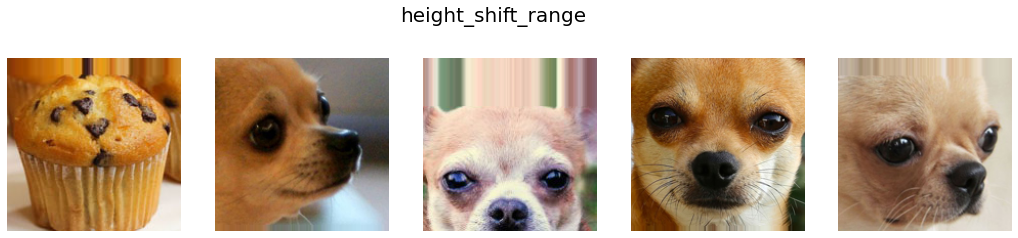

In [7]:
show_augmentaion('height_shift_range', height_shift_range=50)

Found 109 images belonging to 2 classes.


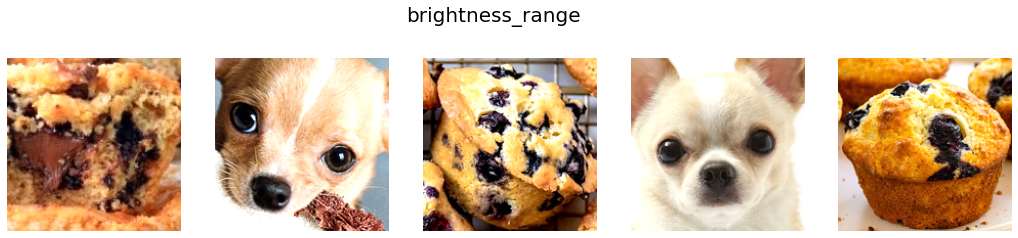

In [8]:
show_augmentaion('brightness_range', brightness_range=(1., 1.2))

Found 109 images belonging to 2 classes.


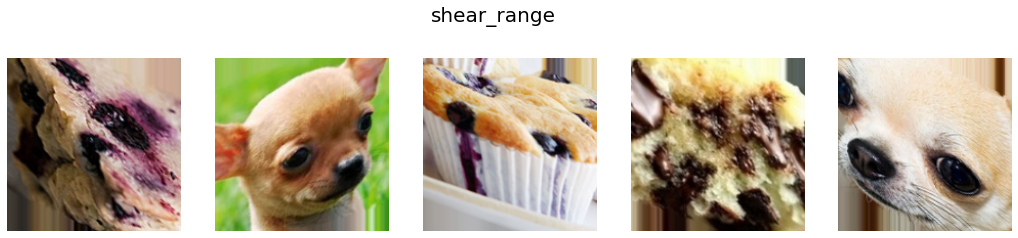

In [9]:
show_augmentaion('shear_range', shear_range=50.0)

Found 109 images belonging to 2 classes.


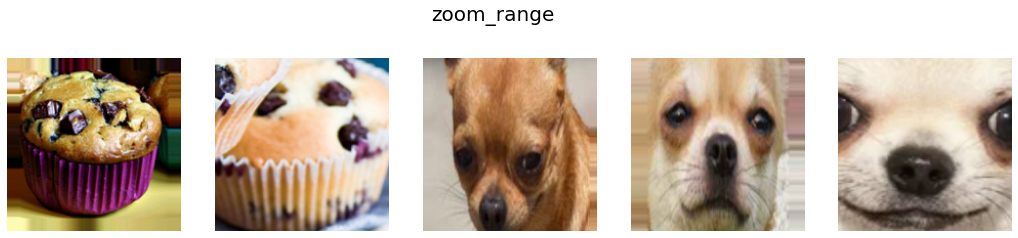

In [10]:
show_augmentaion('zoom_range', zoom_range=0.5)

Found 109 images belonging to 2 classes.


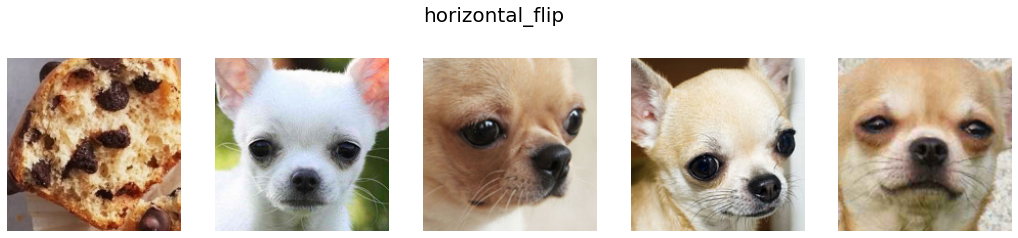

In [11]:
show_augmentaion('horizontal_flip', horizontal_flip=True)

Found 109 images belonging to 2 classes.


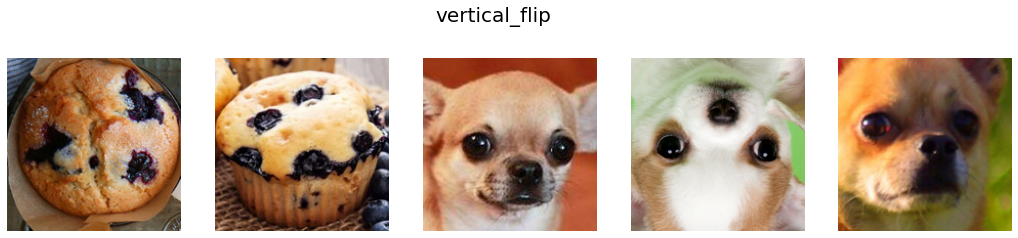

In [12]:
show_augmentaion('vertical_flip', vertical_flip=True)

Found 109 images belonging to 2 classes.


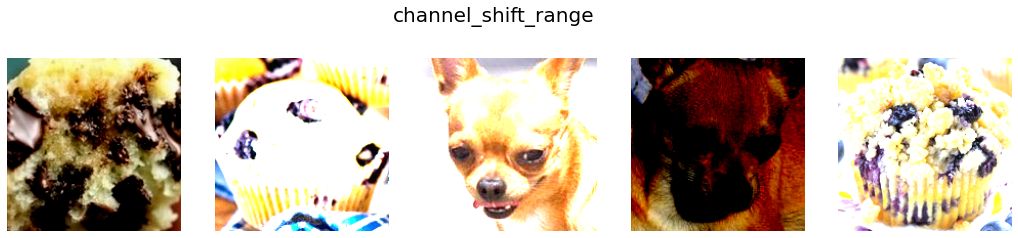

In [13]:
show_augmentaion('channel_shift_range', channel_shift_range=200.)

Found 109 images belonging to 2 classes.


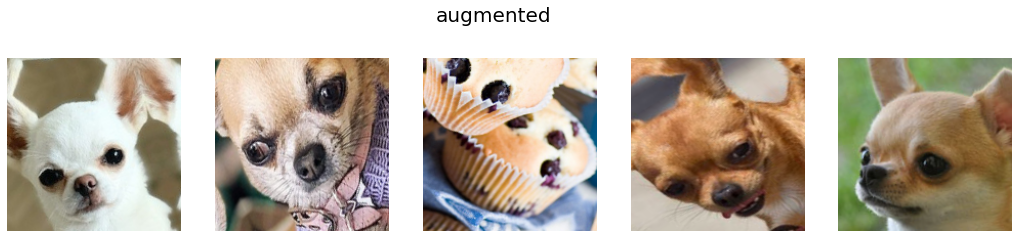

In [14]:
AUGMENTATION_SETTINGS = dict(
    rotation_range=45,
    width_shift_range=20,
    height_shift_range=20,
    zoom_range=0.2,
    fill_mode='reflect',
    horizontal_flip=True
)

show_augmentaion('augmented', **AUGMENTATION_SETTINGS)

## Генераторы изображений

In [15]:
IMAGE_SIZE = (170, 170)


train_val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    **AUGMENTATION_SETTINGS
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_val_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=32,
    subset='training'
)
val_generator = train_val_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=32,
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=1,
)

Found 88 images belonging to 2 classes.
Found 21 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Модели

In [16]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Conv2D,
                                     MaxPooling2D,
                                     Flatten,
                                     Dense,
                                     Dropout)


LAYER_WIDTH_32 = 32
LAYER_WIDTH_64 = 64
INPUT_SHAPE = (170, 170, 3)
KERNEL_SIZE = (3, 3)
POOL_SIZE = (2, 2)


model_32 = Sequential(
    [
        Conv2D(
            filters=LAYER_WIDTH_32,
            kernel_size=KERNEL_SIZE,
            padding='same',
            input_shape=INPUT_SHAPE,
            activation='relu',
            use_bias=True
        ),
        MaxPooling2D(pool_size=POOL_SIZE),
        Conv2D(
            filters=LAYER_WIDTH_32,
            kernel_size=KERNEL_SIZE,
            padding='same',
            activation='relu',
            use_bias=True
        ),
        MaxPooling2D(pool_size=POOL_SIZE),
        Flatten(),
        Dense(LAYER_WIDTH_32, activation='relu'),
        Dropout(0.5),
        Dense(LAYER_WIDTH_32, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax'),
    ]
)

model_64 = Sequential(
    [
        Conv2D(
            filters=LAYER_WIDTH_64,
            kernel_size=KERNEL_SIZE,
            padding='same',
            input_shape=INPUT_SHAPE,
            activation='relu',
            use_bias=True
        ),
        MaxPooling2D(pool_size=POOL_SIZE),
        Conv2D(
            filters=LAYER_WIDTH_64,
            kernel_size=KERNEL_SIZE,
            padding='same',
            activation='relu',
            use_bias=True
        ),
        MaxPooling2D(pool_size=POOL_SIZE),
        Flatten(),
        Dense(LAYER_WIDTH_64, activation='relu'),
        Dropout(0.5),
        Dense(LAYER_WIDTH_64, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax'),
    ]
)

model_32.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_64.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

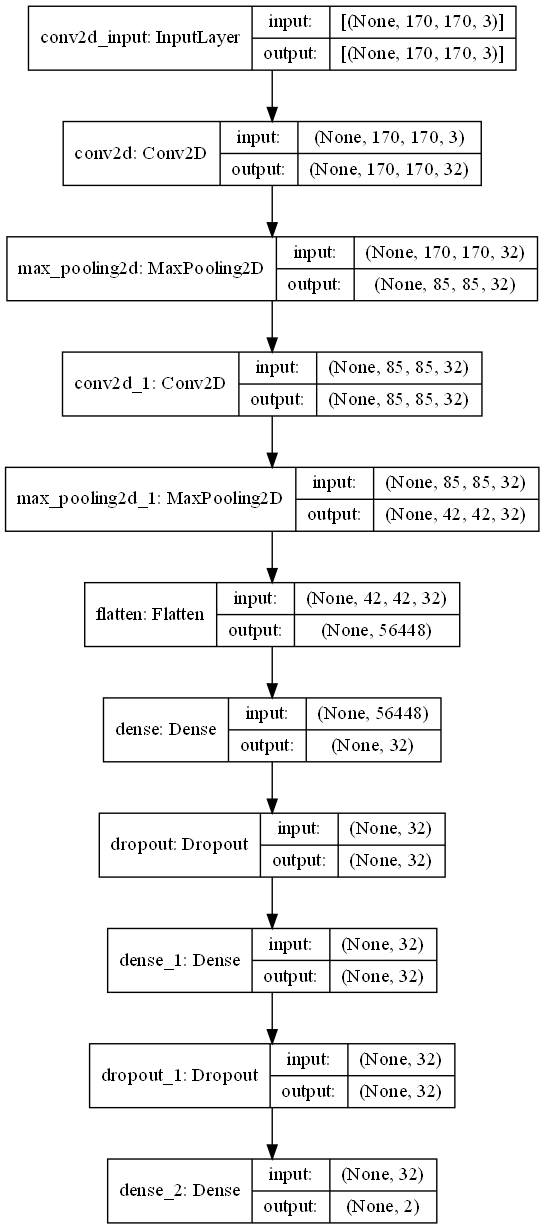

In [17]:
from tensorflow.keras.utils import plot_model


plot_model(model_32, to_file='model_32.png', show_shapes=True, rankdir="TB", dpi=100)

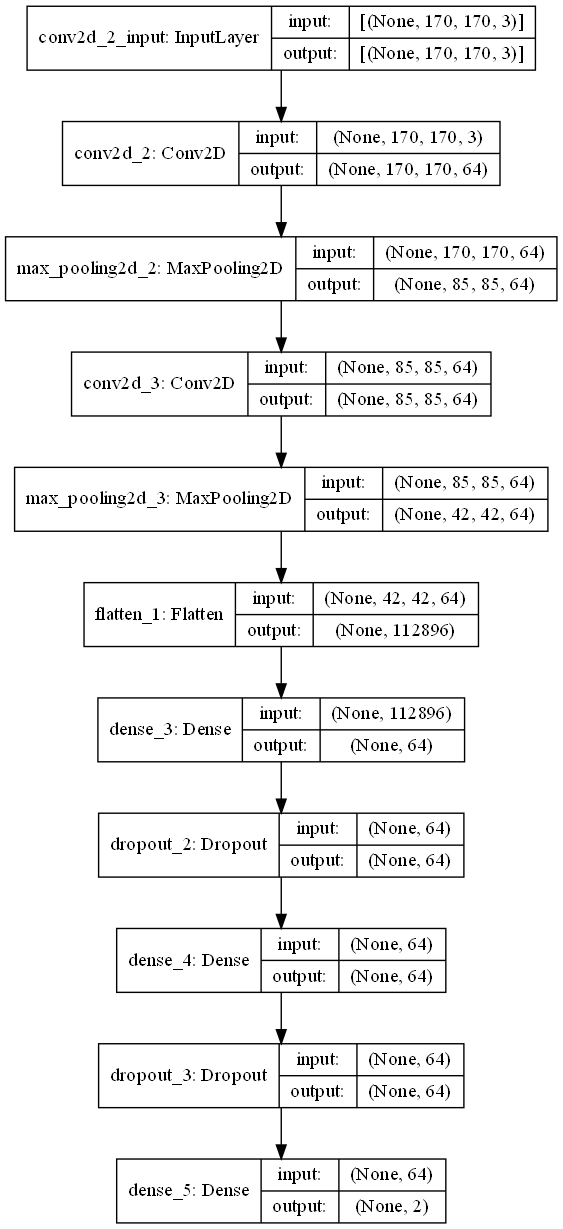

In [18]:
plot_model(model_64, to_file='model_64.png', show_shapes=True, rankdir="TB", dpi=100)

## Обучение

In [19]:
from tensorflow import device
from tensorflow.keras.callbacks import ModelCheckpoint


MODEL_32_PATH = os.path.join(os.getcwd(), 'model_32.hdf5')
MODEL_64_PATH = os.path.join(os.getcwd(), 'model_64.hdf5')


EPOCHS = 250


checkpoint_32 = ModelCheckpoint(
    filepath=MODEL_32_PATH,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
checkpoint_64 = ModelCheckpoint(
    filepath=MODEL_64_PATH,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
callbacks_list_32 = [checkpoint_32]
callbacks_list_64 = [checkpoint_64]

history_32 = model_32.fit(
    train_generator,
    epochs=EPOCHS,
    verbose=0,
    callbacks=callbacks_list_32,
    validation_data=val_generator
)
history_64 = model_64.fit(
    train_generator,
    epochs=EPOCHS,
    verbose=0,
    callbacks=callbacks_list_64,
    validation_data=val_generator
)

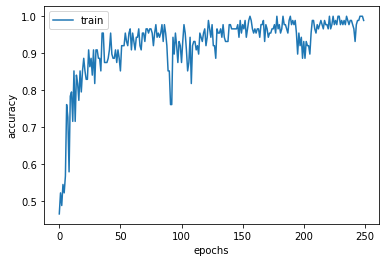

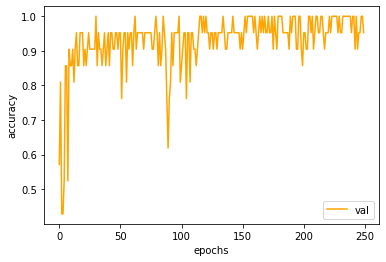

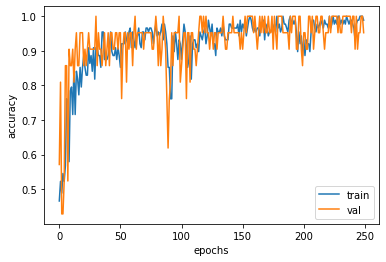

In [20]:
def plot_history(history, mode):
    ax1 = plt.subplot()
    ax1.plot(history.history['%s' % mode])
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('%s' % mode)
    ax1.legend(['train'])
    plt.show()
    
    ax2 = plt.subplot()
    ax2.plot(history.history['val_%s' % mode], color='orange')
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('%s' % mode)
    ax2.legend(['val'])
    plt.show()
    
    ax3 = plt.subplot()
    ax3.plot(history.history['%s' % mode])
    ax3.plot(history.history['val_%s' % mode])
    ax3.set_xlabel('epochs')
    ax3.set_ylabel('%s' % mode)
    ax3.legend(['train', 'val'])
    plt.show()


plot_history(history_32, 'accuracy')

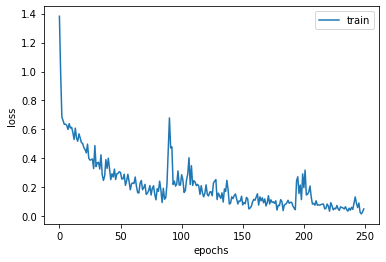

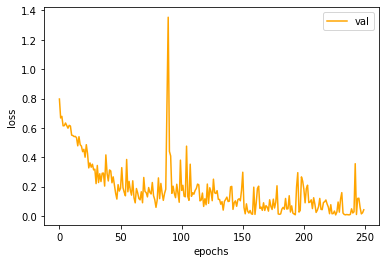

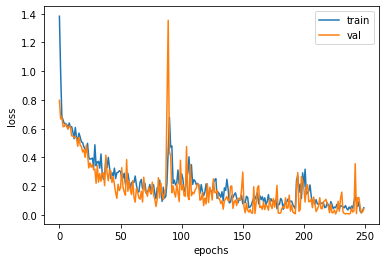

In [21]:
plot_history(history_32, 'loss')

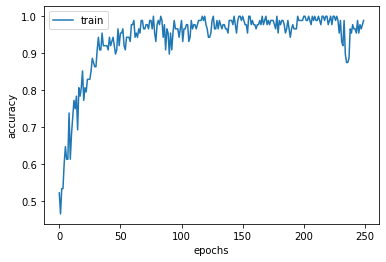

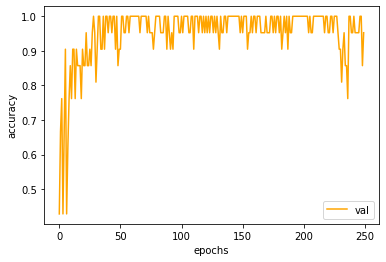

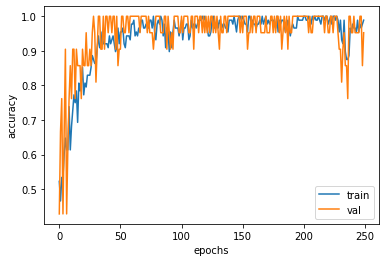

In [22]:
plot_history(history_64, 'accuracy')

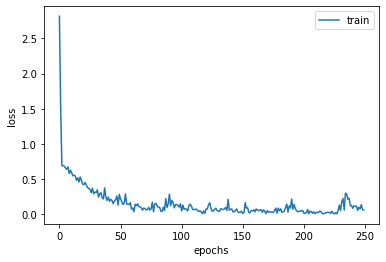

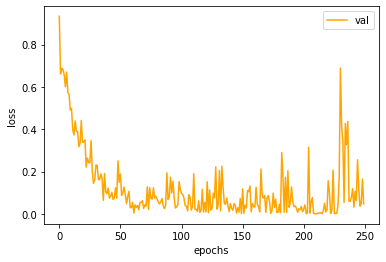

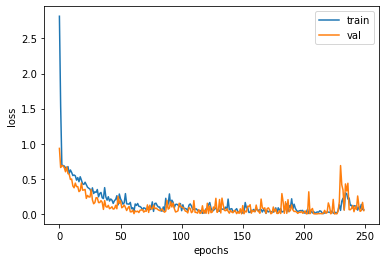

In [23]:
plot_history(history_64, 'loss')

## Тестирование

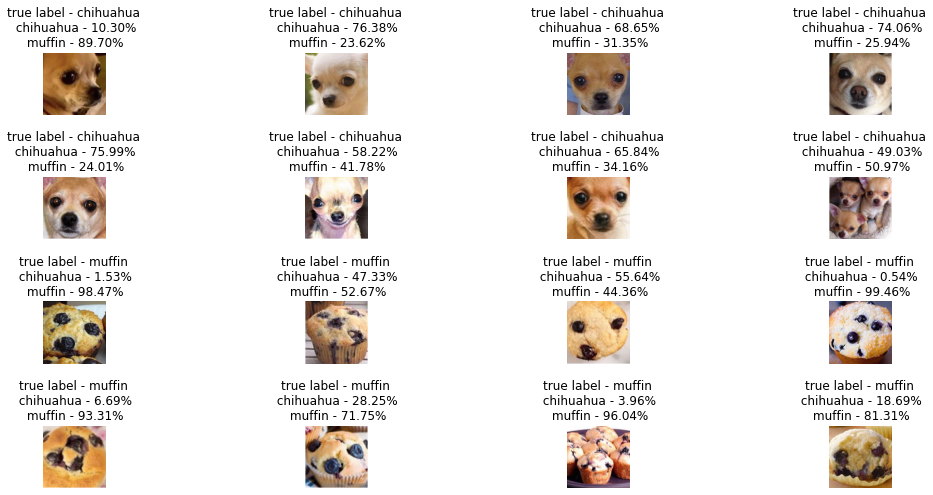

In [24]:
from tensorflow.keras.models import load_model
from tensorflow.io import read_file
from tensorflow.io import decode_jpeg
from tensorflow.image import (convert_image_dtype,
                              resize)
from tensorflow import newaxis
from tensorflow import float32


TEST_CHIHUAHUA = os.path.join(os.getcwd(), 'dataset', 'test', 'Chihuahua')
TEST_MUFFIN = os.path.join(os.getcwd(), 'dataset', 'test', 'Muffin')


test_image_paths_chihuahua = [os.path.join(TEST_CHIHUAHUA, file_name) for file_name in os.listdir(TEST_CHIHUAHUA)]
test_image_paths_muffin = [os.path.join(TEST_MUFFIN, file_name) for file_name in os.listdir(TEST_MUFFIN)]

test_image_paths = test_image_paths_chihuahua + test_image_paths_muffin
true_labels = ['chihuahua'] * len(test_image_paths_chihuahua) + ['muffin'] * len(test_image_paths_muffin)

best_model_32 = load_model(MODEL_32_PATH)
best_model_64 = load_model(MODEL_64_PATH)


def load_image(path):
    raw = read_file(path)
    image = decode_jpeg(raw, channels=3)
    image = convert_image_dtype(image, float32)
    image = image[newaxis]
    return image


def show_predictions(model, test_image_paths, true_labels):
    fig, axes = plt.subplots(4, 4, figsize=(18, 8))
    axes = axes.flatten()

    for ax, test_image_path, label in zip(axes, test_image_paths, true_labels):
        image = plt.imread(test_image_path)
        ax.imshow(image)
        ax.set_axis_off()

        image = load_image(test_image_path)
        predict = model.predict(image)

        ax.set_title(f'true label - {label}\n chihuahua - {predict[0][0]:2.2%}\n muffin - {predict[0][1]:2.2%}')

    plt.subplots_adjust(hspace=1)
    plt.show()
    

show_predictions(best_model_32, test_image_paths, true_labels)

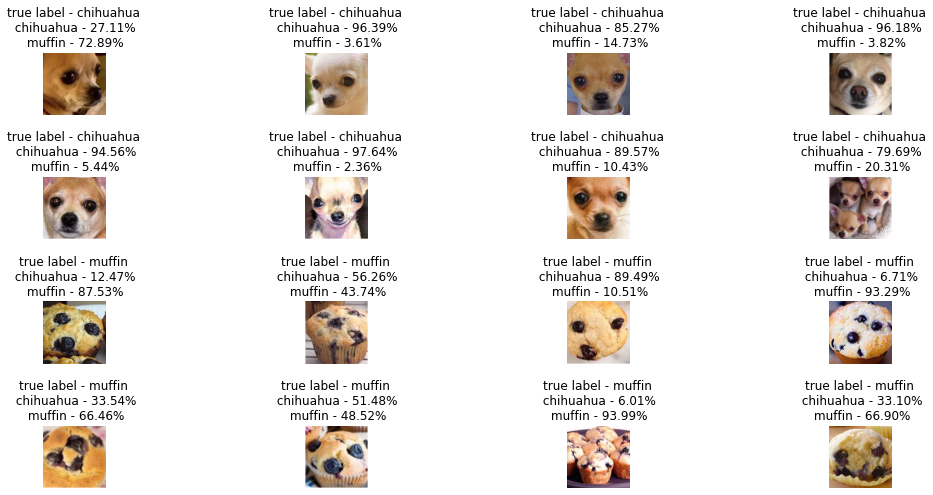

In [25]:
show_predictions(best_model_64, test_image_paths, true_labels)

In [26]:
best_model_32.evaluate(test_generator)

16/16 [==============================] - 0s 10ms/step - loss: 0.4540 - accuracy: 0.8125


[0.4539864659309387, 0.8125]

In [27]:
best_model_64.evaluate(test_generator)

16/16 [==============================] - 0s 18ms/step - loss: 0.4509 - accuracy: 0.7500


[0.45093896985054016, 0.75]